In [1]:
import numpy as np

class BernoulliBandit:
    """
    A simple environment for the multi-armed bandit problem.
    Each arm (article) has a fixed probability of giving a reward (user click).
    """

    def __init__(self, probs):
        """
        Initialize the bandit with a list of probabilities for each arm.

        Input:
            probs (list of float): Probabilities of reward for each arm.
        """
        self.probs = probs
        self.k = len(probs)

    def pull(self, arm):
        """
        Simulate pulling an arm (recommending an article).

        Input:
            arm (int): Index of the arm/article to pull.

        Output:
            reward (int): 1 if user clicks, 0 otherwise.
        """
        return int(np.random.rand() < self.probs[arm])

## Epsilon Greedy

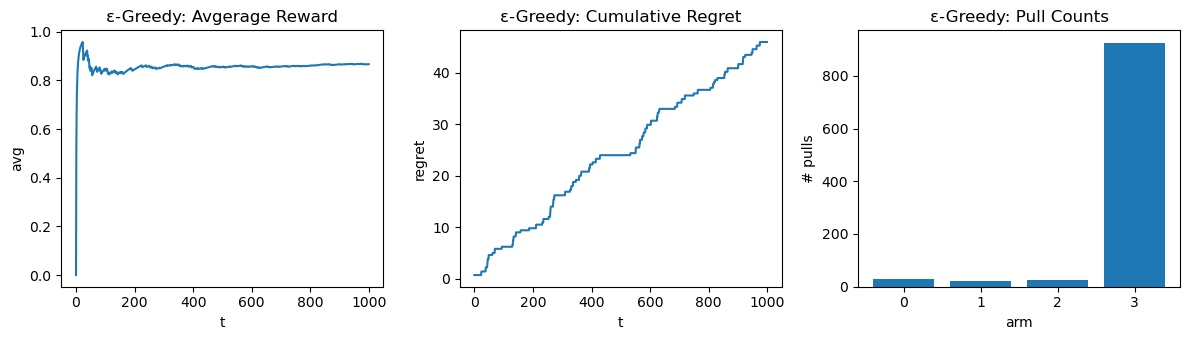

In [2]:
# Epsilon-Greedy — self-contained run function + quick test ========
import numpy as np
import matplotlib.pyplot as plt

def run_epsilon_greedy(probs, T, epsilon=0.1, seed=0):
    """
    Run epsilon-greedy for T steps on a BernoulliBandit with given probs.

    Returns:
        dict: {
          'rewards': np.array[T],
          'regrets': np.array[T],
          'actions': np.array[T],
          'Q': np.array[k],   # final value estimates
          'N': np.array[k],   # pull counts
        }
    """
    assert all(0.0 <= p <= 1.0 for p in probs), "All probabilities must be in [0, 1]"
    bandit = BernoulliBandit(probs)
    rng = np.random.default_rng(seed)

    k = len(probs)
    Q = np.zeros(k, dtype=float)   # value estimates
    N = np.zeros(k, dtype=int)     # pull counts

    rewards = np.zeros(T, dtype=int)
    regrets = np.zeros(T, dtype=float)
    actions = np.zeros(T, dtype=int)

    optimal_mean = float(np.max(probs))

    for t in range(1, T + 1):
        # ----------------------- TODO: ε-greedy selection ----------------------
        # With probability epsilon: choose a random arm.
        # Otherwise: choose the arm with the highest Q (break ties via np.argmax).
        #
        # Hint: rng.random() for the coin flip; rng.integers(0, k) for random arm.
        # Hint: np.argmax(Q) for exploitation.

        #arm = rng.integers(0, k)  # TEMP PLACEHOLDER — replace with ε-greedy
        if rng.random() <= epsilon: # with epsilon probability, explore
            arm = rng.integers(0, k) # randomly select an arm/random action policy
        else:
            arm = np.argmax(Q) # with 1-epsilon probability, exploit

        # ----------------------------------------------------------------------

        r = int(bandit.pull(arm))
        rewards[t - 1] = r
        actions[t - 1] = arm
        regrets[t - 1] = optimal_mean - probs[arm]

        N[arm] += 1
        Q[arm] += (r - Q[arm]) / N[arm]

    return {"rewards": rewards, "regrets": regrets, "actions": actions, "Q": Q, "N": N}

# --- Quick single-run test / visualization for ε-greedy ---

##############################################################
###
### You can play around with these parameters:
###
probs = [0.2, 0.1, 0.5, 0.9]
T = 1000
epsilon = 0.1
seed = 123
##############################################################

out_eps = run_epsilon_greedy(probs, T, epsilon, seed)

plt.figure(figsize=(12, 3.5))
plt.subplot(1, 3, 1)
avg_reward = np.cumsum(out_eps["rewards"]) / np.arange(1, T + 1)
plt.plot(avg_reward); plt.title("ε-Greedy: Avgerage Reward"); plt.xlabel("t"); plt.ylabel("avg")

plt.subplot(1, 3, 2)
plt.plot(np.cumsum(out_eps["regrets"])); plt.title("ε-Greedy: Cumulative Regret"); plt.xlabel("t"); plt.ylabel("regret")

plt.subplot(1, 3, 3)
counts = np.bincount(out_eps["actions"], minlength=len(probs))
plt.bar(range(len(probs)), counts); plt.title("ε-Greedy: Pull Counts"); plt.xlabel("arm"); plt.ylabel("# pulls")
plt.tight_layout(); plt.show()

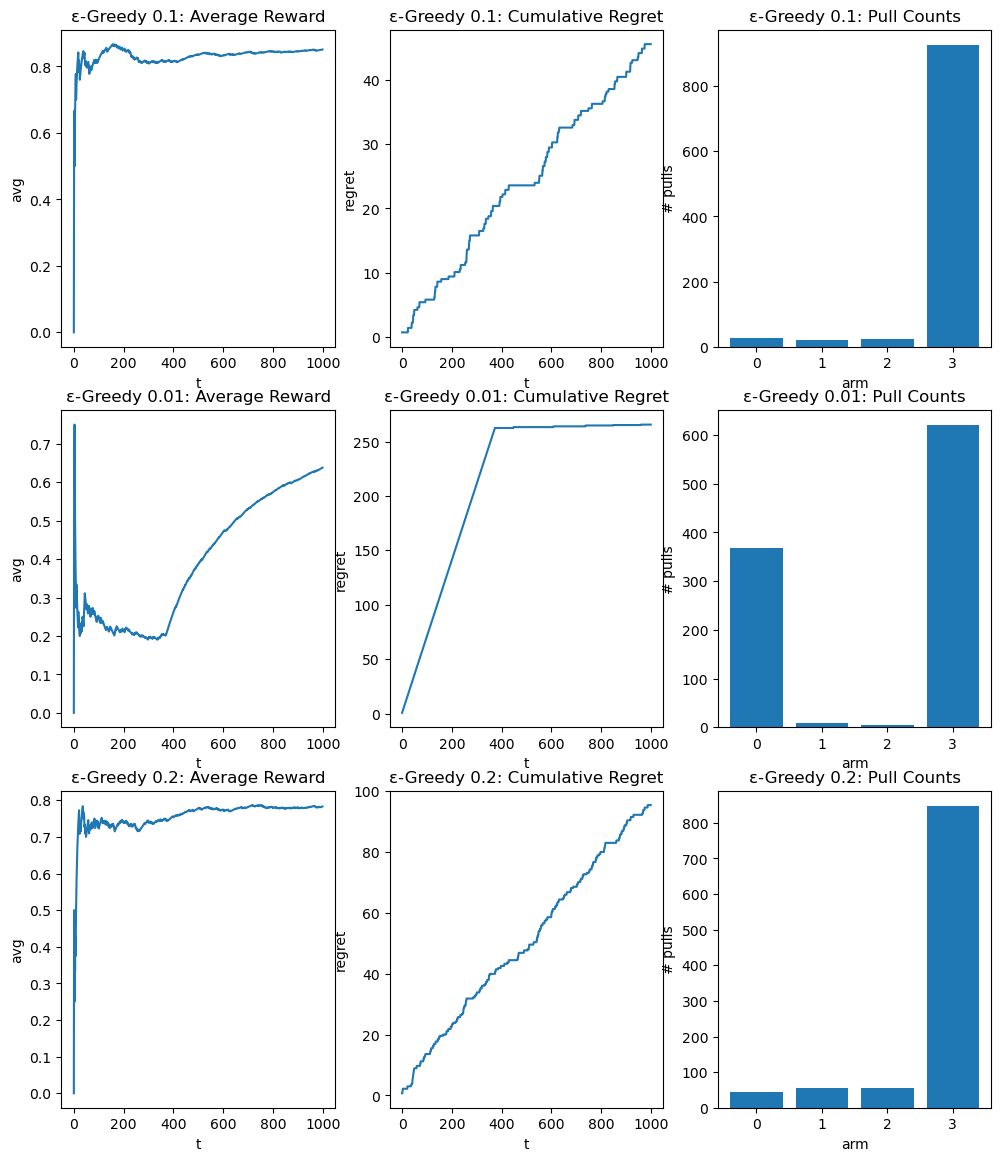

In [3]:
# --- Multiple ε values comparison ---
probs = [0.2, 0.1, 0.5, 0.9]
T = 1000
seed = 123
epsilon_values = [0.1, 0.01, 0.2]

fig, axes = plt.subplots(len(epsilon_values), 3, figsize=(12, 14))
for i, epsilon in enumerate(epsilon_values):
    out_eps = run_epsilon_greedy(probs, T, epsilon, seed)

    avg_reward = np.cumsum(out_eps["rewards"]) / np.arange(1, T + 1)
    axes[i, 0].plot(avg_reward)
    axes[i, 0].set_title(f"ε-Greedy {epsilon}: Average Reward")
    axes[i, 0].set_xlabel("t")
    axes[i, 0].set_ylabel("avg")

    regrets = np.cumsum(out_eps["regrets"])
    axes[i, 1].plot(regrets)
    axes[i, 1].set_title(f"ε-Greedy {epsilon}: Cumulative Regret")
    axes[i, 1].set_xlabel("t")
    axes[i, 1].set_ylabel("regret")

    counts = np.bincount(out_eps["actions"], minlength=len(probs))
    axes[i, 2].bar(range(len(probs)), counts)
    axes[i, 2].set_title(f"ε-Greedy {epsilon}: Pull Counts")
    axes[i, 2].set_xlabel("arm")
    axes[i, 2].set_ylabel("# pulls")

## UCB

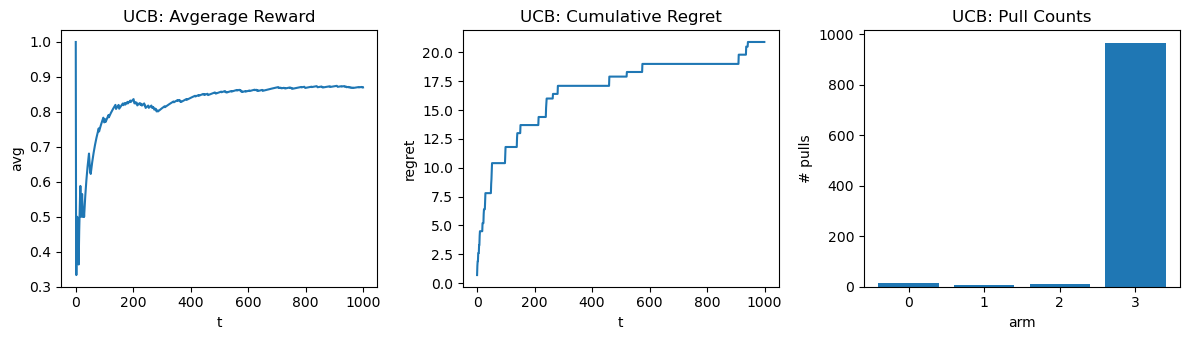

In [4]:
# UCB — self-contained run function + quick test ===================

def run_ucb(probs, T, c=1.0, seed=0):
    """
    Run Upper Confidence Bound (UCB) for T steps on a BernoulliBandit.

    Returns:
        dict: same structure as run_epsilon_greedy
    """
    assert all(0.0 <= p <= 1.0 for p in probs), "All probabilities must be in [0, 1]"
    bandit = BernoulliBandit(probs)
    rng = np.random.default_rng(seed)

    k = len(probs)
    Q = np.zeros(k, dtype=float)
    N = np.zeros(k, dtype=int)
    UCB = np.zeros(k, dtype=float)

    rewards = np.zeros(T, dtype=int)
    regrets = np.zeros(T, dtype=float)
    actions = np.zeros(T, dtype=int)

    optimal_mean = float(np.max(probs))

    for t in range(1, T + 1):
        # --------------------------- TODO: UCB selection -----------------------
        # Compute: UCB[a] = Q[a] + c * sqrt( (ln(t)) / N[a] )
        # If N[a] == 0, set UCB[a] = +inf so each arm is tried at least once.
        # Then choose the arm with the largest UCB[a].
        #
        # Hints:
        #   - Use np.inf for infinity, np.log(t) for log.
        #   - Create an array of UCB values of length k.

        #arm = rng.integers(0, k)  # TEMP PLACEHOLDER — replace with UCB rule
        for a in range(k):
            if N[a] == 0:
                UCB[a] = np.inf
            else:
                UCB[a] = Q[a] + c * np.sqrt( (np.log(t)) / N[a])
        arm = np.argmax(UCB)

        # ----------------------------------------------------------------------

        r = int(bandit.pull(arm))
        rewards[t - 1] = r
        actions[t - 1] = arm
        regrets[t - 1] = optimal_mean - probs[arm]

        N[arm] += 1
        Q[arm] += (r - Q[arm]) / N[arm]

    return {"rewards": rewards, "regrets": regrets, "actions": actions, "Q": Q, "N": N}

# --- Quick single-run test / visualization for UCB ---

##############################################################
###
### You can play around with these parameters:
###
probs = [0.2, 0.1, 0.5, 0.9]
T = 1000
c=1.0
seed=123
##############################################################


out_ucb = run_ucb(probs, T, c, seed)

plt.figure(figsize=(12, 3.5))
plt.subplot(1, 3, 1)
avg_reward = np.cumsum(out_ucb["rewards"]) / np.arange(1, T + 1)
plt.plot(avg_reward); plt.title("UCB: Avgerage Reward"); plt.xlabel("t"); plt.ylabel("avg")

plt.subplot(1, 3, 2)
plt.plot(np.cumsum(out_ucb["regrets"])); plt.title("UCB: Cumulative Regret"); plt.xlabel("t"); plt.ylabel("regret")

plt.subplot(1, 3, 3)
counts = np.bincount(out_ucb["actions"], minlength=len(probs))
plt.bar(range(len(probs)), counts); plt.title("UCB: Pull Counts"); plt.xlabel("arm"); plt.ylabel("# pulls")
plt.tight_layout(); plt.show()


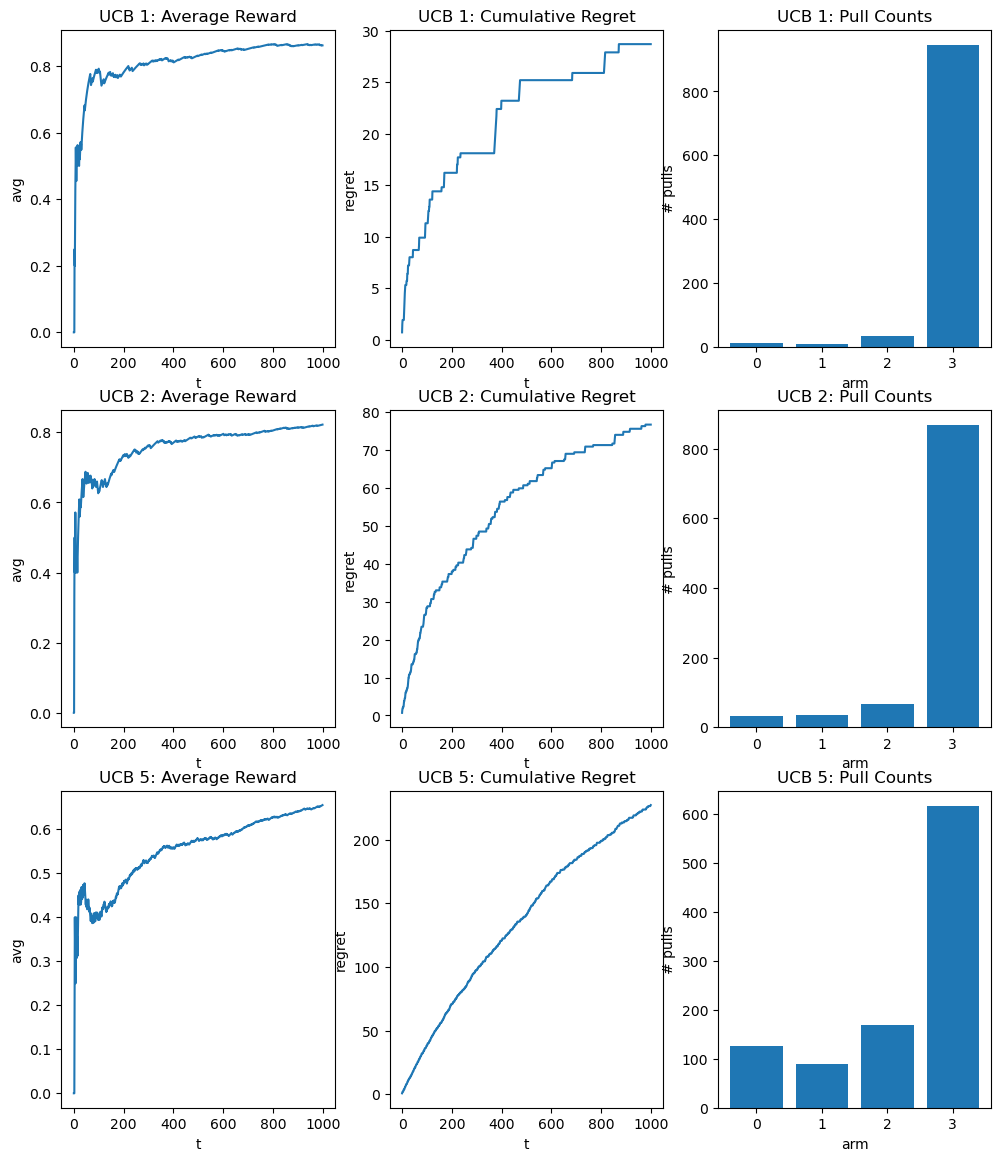

In [5]:
#-- Multiple c values comparison ---

probs = [0.2, 0.1, 0.5, 0.9]
T = 1000
seed = 123
c_values = [1, 2, 5]

fig, axes = plt.subplots(len(c_values), 3, figsize=(12, 14))
for i, c in enumerate(c_values):
    out_ucb = run_ucb(probs, T, c, seed)

    avg_reward = np.cumsum(out_ucb["rewards"]) / np.arange(1, T + 1)
    axes[i, 0].plot(avg_reward)
    axes[i, 0].set_title(f"UCB {c}: Average Reward")
    axes[i, 0].set_xlabel("t")
    axes[i, 0].set_ylabel("avg")

    regrets = np.cumsum(out_ucb["regrets"])
    axes[i, 1].plot(regrets)
    axes[i, 1].set_title(f"UCB {c}: Cumulative Regret")
    axes[i, 1].set_xlabel("t")
    axes[i, 1].set_ylabel("regret")

    counts = np.bincount(out_ucb["actions"], minlength=len(probs))
    axes[i, 2].bar(range(len(probs)), counts)
    axes[i, 2].set_title(f"UCB {c}: Pull Counts")
    axes[i, 2].set_xlabel("arm")
    axes[i, 2].set_ylabel("# pulls")